# Natural Language Processing

## Part 2: TorchText + GRU + Reusing Context Vectors + Teaching Forcing


In this second notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078). 

One downside of the previous model is that the decoder is trying to cram lots of information into the hidden states. Whilst decoding, the hidden state will need to contain information about the whole of the source sequence, as well as all of the tokens have been decoded so far. By alleviating some of this information compression, we can create a better model!

We'll also be using a GRU (Gated Recurrent Unit) instead of an LSTM (Long Short-Term Memory). Is a GRU better than an LSTM? [Research](https://arxiv.org/abs/1412.3555) has shown they're pretty much the same but which GRU is lighter, and both are better than standard RNNs. 

**Note**: skip to the model part; everything else is the same as part 1.

In [1]:
import torch, torchdata, torchtext
from torch import nn

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
torchtext.__version__

'0.14.0'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
#uncomment this if you are not using our department puffer
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'de'

train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
sample = next(iter(train))
sample

('Two young, White males are outside near many bushes.',
 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.')

In [8]:
train_size = len(list(iter(train)))
train_size

29001

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [9]:
train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [10]:
train_size = len(list(iter(train)))
train_size

20301

In [11]:
val_size = len(list(iter(val)))
val_size

5800

In [12]:
test_size = len(list(iter(test)))
test_size

2900

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [13]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [14]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

In [15]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  Two young, White males are outside near many bushes.
Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


A function to tokenize our input.

In [16]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [17]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [18]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [19]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[1891, 10, 4, 0, 4]

In [20]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'here'

In [21]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [22]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [23]:
#check unique vocabularies
len(mapping)

5174

## 4. Preparing the dataloader

We gonna first prepare the pipeline, which we first (1) tokenize, then (2) numeralize, then (3) append BOS/EOS on each sample.   To make our life easy, we create a function to apply these transforms.

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, trg_batch


Create train, val, and test dataloaders

In [25]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [26]:
for en, de in train_loader:
    break

In [27]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("German shape: ", de.shape)   # (seq len, batch_size)

English shape:  torch.Size([27, 64])
German shape:  torch.Size([24, 64])


## 5. Design the model

### Encoder

The encoder is similar to the previous one, with the multi-layer LSTM swapped for a single-layer GRU. We also don't pass the dropout as an argument to the GRU as that dropout is used between each layer of a multi-layered RNN. As we only have a single layer, PyTorch will display a warning if we try and use pass a dropout value to it.

Another thing to note about the GRU is that it only requires and returns a hidden state, there is no cell state like in the LSTM.

$$\begin{align*}
h_t &= \text{GRU}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})\\
h_t &= \text{RNN}(e(x_t), h_{t-1})
\end{align*}$$

From the equations above, it looks like the RNN and the GRU are identical. Inside the GRU, however, is a number of *gating mechanisms* that control the information flow in to and out of the hidden state (similar to an LSTM). Again, for more info, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) excellent post. 

The rest of the encoder should be very familar from the last tutorial, it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, passes it through the embedding layer, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(e(x_t), h_{t-1})$$

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim) #no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [seq len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        #embedded = [seq len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded) #no cell state!
        #outputs = [seq len,  batch size, hid dim]
        #hidden  = [n layers, batch size, hid dim]
        
        #outputs are always from the most top hidden layer
        
        return hidden

### Decoder

The decoder is where the implementation differs significantly from the previous model and we alleviate some of the information compression.

Instead of the GRU in the decoder taking just the embedded target token, $d(y_t)$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$. 

$$s_t = \text{DecoderGRU}(d(y_t), s_{t-1}, z)$$

Note how this context vector, $z$, does not have a $t$ subscript, meaning we re-use the same context vector returned by the encoder for every time-step in the decoder. 

Before, we predicted the next token, $\hat{y}_{t+1}$, with the linear layer, $f$, only using the top-layer decoder hidden state at that time-step, $s_t$, as $\hat{y}_{t+1}=f(s_t^L)$. Now, we also pass the embedding of current token, $d(y_t)$ and the context vector, $z$ to the linear layer.

$$\hat{y}_{t+1} = f(d(y_t), s_t, z)$$

Thus, our decoder now looks something like this:

<img src = "figures/seq2seq6.png" width="200">

Note, the initial hidden state, $s_0$, is still the context vector, $z$, so when generating the first token we are actually inputting two identical context vectors into the GRU.

How do these two changes reduce the information compression? Well, hypothetically the decoder hidden states, $s_t$, no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of $y_t$ to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state. 

However, this hypothesis is just a hypothesis, it is impossible to determine how the model actually uses the information provided to it (don't listen to anyone that says differently). Nevertheless, it is a solid intuition and the results seem to indicate that this modifications are a good idea!  **Designing neural network is all about imagination; it can be so wrong or so right.**

Within the implementation, we will pass $d(y_t)$ and $z$ to the GRU by concatenating them together, so the input dimensions to the GRU are now `emb_dim + hid_dim` (as context vector will be of size `hid_dim`). The linear layer will take $d(y_t), s_t$ and $z$ also by concatenating them together, hence the input dimensions are now `emb_dim + hid_dim*2`. We also don't pass a value of dropout to the GRU as it only uses a single layer.

`forward` now takes a `context` argument. Inside of `forward`, we concatenate $y_t$ and $z$ as `emb_con` before feeding to the GRU, and we concatenate $d(y_t)$, $s_t$ and $z$ together as `output` before feeding it through the linear layer to receive our predictions, $\hat{y}_{t+1}$.

In [29]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc  = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_, hidden, context):
        
        #note: n layers = 1
        
        #input   = [batch size]
        #hidden  = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input_ = input_.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input_))
        #embedded = [1, batch size, emb dim]
                
        emb_con = torch.cat((embedded, context), dim = 2)
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.gru(emb_con, hidden)
        #output = [seq len,  batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]

        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim = 1)        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc(output)
        #prediction = [batch size, output dim]
        
        return prediction, hidden

### Putting them together (become Seq2Seq!)

Putting the encoder and decoder together, we get:

<img src="figures/seq2seq7.png" width="400">

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive a `context` vector
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)

In [30]:
class Seq2SeqGRU(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is the context
        context = self.encoder(src)
        
        #context also used as the initial hidden state of the decoder
        hidden = context
        
        #first input to the decoder is the <sos> tokens
        input_ = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input_, hidden, context)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input_ = trg[t] if teacher_force else top1

        return outputs

## 6. Training

The rest is very similar to the previous ones.

In [31]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [32]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5

enc = Encoder(input_dim,  emb_dim, hid_dim, dropout)
dec = Decoder(output_dim, emb_dim, hid_dim, dropout)

model = Seq2SeqGRU(enc, dec, device).to(device)
model.apply(initialize_weights)

Seq2SeqGRU(
  (encoder): Encoder(
    (embedding): Embedding(5174, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6433, 256)
    (gru): GRU(768, 512)
    (fc): Linear(in_features=1280, out_features=6433, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [33]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1324544
393216
786432
  1536
  1536
1646848
1179648
786432
  1536
  1536
8234240
  6433
______
14363937


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [34]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

The training is very similar to part 1.

In [35]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [36]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [37]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 52s
	Train Loss: 4.554 | Train PPL:  95.037
	 Val. Loss: 4.198 |  Val. PPL:  66.540
Epoch: 02 | Time: 0m 51s
	Train Loss: 3.496 | Train PPL:  32.973
	 Val. Loss: 3.524 |  Val. PPL:  33.929
Epoch: 03 | Time: 0m 52s
	Train Loss: 3.043 | Train PPL:  20.962
	 Val. Loss: 3.225 |  Val. PPL:  25.163
Epoch: 04 | Time: 0m 51s
	Train Loss: 2.715 | Train PPL:  15.109
	 Val. Loss: 2.960 |  Val. PPL:  19.302
Epoch: 05 | Time: 0m 51s
	Train Loss: 2.508 | Train PPL:  12.284
	 Val. Loss: 2.816 |  Val. PPL:  16.702
Epoch: 06 | Time: 0m 52s
	Train Loss: 2.328 | Train PPL:  10.253
	 Val. Loss: 2.682 |  Val. PPL:  14.618
Epoch: 07 | Time: 0m 51s
	Train Loss: 2.190 | Train PPL:   8.932
	 Val. Loss: 2.604 |  Val. PPL:  13.512
Epoch: 08 | Time: 0m 51s
	Train Loss: 2.108 | Train PPL:   8.228
	 Val. Loss: 2.541 |  Val. PPL:  12.694
Epoch: 09 | Time: 0m 54s
	Train Loss: 2.007 | Train PPL:   7.439
	 Val. Loss: 2.481 |  Val. PPL:  11.955
Epoch: 10 | Time: 1m 1s
	Train Loss: 1.944 | Train PPL:

Text(0, 0.5, 'loss')

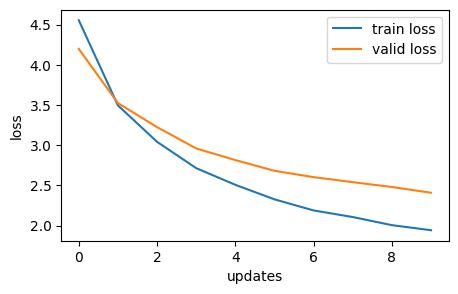

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [41]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.446 | Test PPL:  11.537 |


In [42]:
model

Seq2SeqGRU(
  (encoder): Encoder(
    (embedding): Embedding(5174, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6433, 256)
    (gru): GRU(768, 512)
    (fc): Linear(in_features=1280, out_features=6433, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## 7. Test on some random news

In [43]:
sample[0]

'Two young, White males are outside near many bushes.'

In [44]:
sample[1]

'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'

In [45]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,   19,   25,   15, 1069,  842,   17,   56,   84,  331, 1623,    5,
           3], device='cuda:0')

In [46]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,   21,   83,  262,   32,   89,   22,   91,    7,   16,  115,    0,
        2893,    4,    3], device='cuda:0')

In [47]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [48]:
trg_text = trg_text.reshape(-1, 1)

In [49]:
src_text.shape, trg_text.shape

(torch.Size([13, 1]), torch.Size([15, 1]))

In [50]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output = model(src_text, trg_text, 0) #turn off teacher forcing

In [51]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([15, 1, 6433])

Since batch size is 1, we just take off that dimension

In [52]:
output = output.squeeze(1)

In [53]:
output.shape

torch.Size([15, 6433])

We shall remove the first token since it's zeroes anyway

In [54]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([14, 6433])

Then we just take the top token with highest probabilities

In [55]:
output_max = output.argmax(1) #returns max indices

In [56]:
output_max

tensor([  21,   83,   32,   89,  139,    7,   16,  115, 2893, 2893, 2893,    4,
           3,    3], device='cuda:0')

Get the mapping of the target language

In [57]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [58]:
for token in output_max:
    print(mapping[token.item()])

Zwei
junge
Männer
sind
draußen
in
der
Nähe
Büsche
Büsche
Büsche
.
<eos>
<eos>


## Conclusion

It looks better.  Next tutorial we can try attention.